In [139]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Suffix, single-output decoding',
    'Avg suffix': 'Suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(
            SUFFIX_LEGEND_REMAP) + ' (' + suffix_results['n_shots'].astype(str) + '-Ex.)'
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] < 10)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

def fix_legend__suffix(s: str) -> str:
    return s.replace('1-Ex.', 'Zero-shot').replace('5-Ex.', '4-shot')
suffix_results["legend"] = suffix_results["legend"].map(fix_legend__suffix)

In [95]:
suffix_results["legend"]

41     Suffix, average-output decoding (Zero-shot)
35        Suffix, average-output decoding (4-shot)
37     Suffix, average-output decoding (Zero-shot)
43        Suffix, average-output decoding (4-shot)
48     Suffix, average-output decoding (Zero-shot)
33        Suffix, average-output decoding (4-shot)
49     Suffix, average-output decoding (Zero-shot)
53        Suffix, average-output decoding (4-shot)
61     Suffix, average-output decoding (Zero-shot)
64        Suffix, average-output decoding (4-shot)
0         Suffix, average-output decoding (4-shot)
9      Suffix, average-output decoding (Zero-shot)
28        Suffix, average-output decoding (4-shot)
76     Suffix, average-output decoding (Zero-shot)
98     Suffix, average-output decoding (Zero-shot)
92        Suffix, average-output decoding (4-shot)
107    Suffix, average-output decoding (Zero-shot)
94        Suffix, average-output decoding (4-shot)
82        Suffix, average-output decoding (4-shot)
99     Suffix, average-output d

In [30]:
suffix_results[['checkpoint',  'task_name', 'n_shots']].value_counts()

checkpoint           task_name      n_shots
EleutherAI/gpt-j-6B  add_two        1          1
                                    5          1
                     subtract_two   1          1
                     square_one     5          1
                                    1          1
                     multiply_two   5          1
                                    1          1
                     max_two        5          1
                                    1          1
                     first_two      5          1
                                    1          1
                     fibonacci_one  5          1
                                    1          1
                     exp_one        5          1
                                    1          1
                     double_one     5          1
                                    1          1
                     divide_two     5          1
                                    1          1
                     subt

In [166]:
from typing import Dict

nice_method_names = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'EvoPrompt',
}
def get_legend__autoprompt(row: Dict) -> str:
    nss = 'Zero-shot' if row['n_shots'] == 1 else f'{row["n_shots"]-1}-shot'
    return nice_method_names.get(row["model_cls"]) + f' ({nss})'


autoprompt_save_dir = '/home/johnmorris/interpretable-autoprompting/results/autoprompt_arithmetic'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()
autoprompt_results = autoprompt_results[autoprompt_results["num_learned_tokens"] == 6]
autoprompt_results["legend"] = autoprompt_results.apply(get_legend__autoprompt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.40it/s]

skipping Sep_25_19_30_dwtgmlqucavl
skipping Sep_25_19_46_dwtgmlqucavl
skipping Sep_25_19_56_dwtgmlqucavl
skipping Sep_25_19_59_dwtgmlqucavl
skipping Sep_25_20_13_dwtgmlqucavl


In [153]:
autoprompt_results["num_learned_tokens"].value_counts()

6    34
3    33
Name: num_learned_tokens, dtype: int64

In [161]:
pd.set_option('display.max_rows', 100)

r.groupby(["legend", "task_name", "n_shots", "num_learned_tokens"])[["reciprocal_rank", "prefixes", "max_digit"]].first()

reciprocal_rank  \
legend                 task_name     n_shots num_learned_tokens                    
AutoPrompt (4-shot)    add_two       5       3.0                        1.000000   
                       double_one    5       3.0                        0.000100   
                       first_two     5       3.0                        0.000100   
                       max_two       5       3.0                        0.000100   
                       multiply_two  5       3.0                        0.000100   
                       square_one    5       3.0                        0.000100   
                       subtract_two  5       6.0                        1.000000   
AutoPrompt (Zero-shot) add_two       1       3.0                        0.035714   
                       divide_two    1       3.0                        0.000100   
                       double_one    1       3.0                        0.000100   
                       exp_one       1       3.0                        0.000100   
                       fibonacci_one 1       3.0                        0.000100   
                       first_two     1       3.0                        0.000100   
                       max_two       1       3.0                        0.000100   
                       multiply_two  1       3.0                        1.000000   
                       square_one    1       3.0                        0.000100   
                       subtract_two  1       3.0                        0.000100   
EvoPrompt (4-shot)     add_two       5       3.0                        1.000000   
                       double_one    5       3.0                        0.125000   
                       exp_one       5       3.0                        0.000100   
                       first_two     5       3.0                        1.000000   
                       max_two       5       3.0                        1.000000   
                       multiply_two  5       3.0                        0.000100   
                       square_one    5       3.0                        0.500000   
                       subtract_two  5       3.0                        0.066667   
EvoPrompt (Zero-shot)  add_two       1       3.0                        1.000000   
                       divide_two    1       3.0                        1.000000   
                       double_one    1       3.0                        0.125000   
                       exp_one       1       3.0                        0.007812   
                       fibonacci_one 1       3.0                        0.000100   
                       first_two     1       3.0                        0.500000   
                       max_two       1       6.0                        1.000000   
                       multiply_two  1       3.0                        1.000000   
                       square_one    1       3.0                        0.000100   
                       subtract_two  1       3.0                        1.000000   

                                                                                          prefixes  \
legend                 task_name     n_shots num_learned_tokens                                      
AutoPrompt (4-shot)    add_two       5       3.0                    <|endoftext|> add<|endoftext|>   
                       double_one    5       3.0                                         (+am that   
                       first_two     5       3.0                                      majority--80   
                       max_two       5       3.0                                     top nit comma   
                       multiply_two  5       3.0                      first unanimously multiplied   
                       square_one    5       3.0                                          �Multthe   
                       subtract_two  5       6.0                  ViolenceJewsis subtractthe lower   
AutoPrompt (Zero-shot) add_two       1

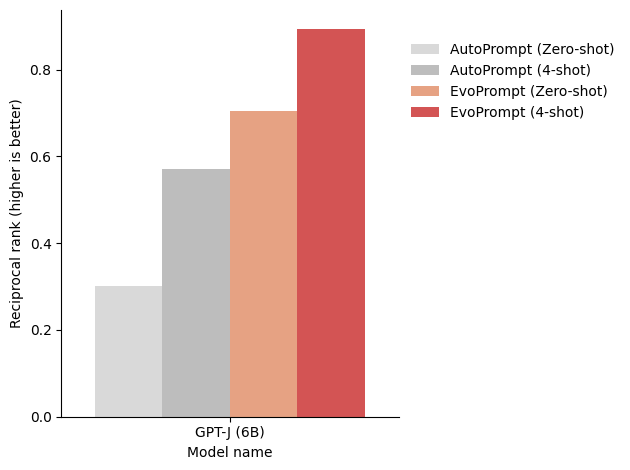

In [177]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (autoprompt_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [172]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

In [208]:
tn = r[["task_name"]].value_counts().reset_index()
finished_task_names = tn[tn[0]==tn[0].max()]["task_name"].tolist()
rf = r[r["task_name"].map(lambda t: t in finished_task_names)] # r_finished

In [ ]:
len(r

7

In [216]:
len(r), len(rf)

(54, 42)

In [ ]:
len(suffix_res

In [224]:
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    plt.figure(figsize=(19, 8))
    # plt.figure(figsize=(10, 3.5))
    tab = ((r
            # (mean over templates, task_name)
            .groupby(['legend', 'n_shots'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    sns.barplot(
        x='n_shots',
        y=tab[metric_key], 
        hue=tab['legend'], 
        hue_order=analyze_utils.get_hue_order(tab['legend']), 
        order=[1, 4], 
        palette=analyze_utils.COLORS
    )
    plt.grid()
    plt.ylim((0.1, 1.0))
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    # plt.legend('', frameon=False)
    plt.show()

ValueError: Could not interpret input 'n_shots'

<Figure size 1900x800 with 0 Axes>

### Plot the best model

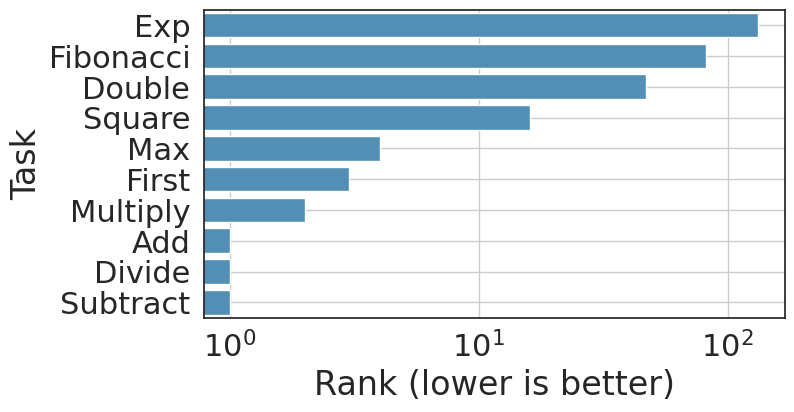

In [185]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (4-shot)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

In [21]:
r[r['legend'] == 'Suffix, average-output decoding (5-Ex.)'].reset_index()['task_name'].value_counts()

fibonacci_one    4
square_one       4
double_one       4
exp_one          4
multiply_two     4
max_two          4
add_two          4
divide_two       4
first_two        4
subtract_two     4
Name: task_name, dtype: int64